# #DuBoisChallenge2024 Challenge 04

Alright, this notebook is a bit different. I had a hard time recreating the fourth plate of the challenge. If I understand the original design correctly, it includes some custom shapes and paths. The data provided for the challenge gives more detailed information, but it doesn't match the the original visual that well.

After various attempts of loading shapes per country and county, I decided to work towards a data driven visual using only data provided in the challenge (mostly). 

The steps we follow are:

1. Load the data
2. Data preparation
3. Visualise the data on a flat map
4. Visualise the data on a globe projection

But first, we load the required packages:

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from colors import dubois_colors
%matplotlib notebook

## 1. Load the data

We start by loading the challenge data. I decide to give both data sets a look:

In [3]:
df_routepairs = pd.read_csv('2024/challenge04/route-pairs.csv')
df_routepairs.head(5)

,Count,Source,Destination
0,1931,Costa da Mina,"Bahia, port unspecified"
1,1592,NaN,NaN
2,1256,Luanda,Rio de Janeiro
3,1107,"Africa., port unspecified",NaN
4,864,"Africa., port unspecified",Havana


In [4]:
df_routes = pd.read_csv('2024/challenge04/routes.csv')
df_routes.head(5)

,voyage_id,ship_name,port_origin,place_of_purchase,port_arrival,year_arrival,n_slaves_arrived,captains_name
0,81711,Hannah,Liverpool,Calabar,"St. Vincent, port unspecified",1787,390.0,"Smith, Bryan"
1,81712,Hannah,Liverpool,New Calabar,"Grenada, port unspecified",1789,351.0,"Wilson, Charles"
2,81713,Hannah,Liverpool,"Bight of Biafra and Gulf of Guinea Islands, po...",Kingston,1789,303.0,"Wilson, Charles"
3,81714,Hannah,Liverpool,Bonny,"St. Vincent, port unspecified",1791,316.0,"Young, William"
4,81715,Hannah,Liverpool,Congo River,"Grenada, port unspecified",1792,331.0,"Young, William"


Of the two data sets, I think the route pairs are an intersting data set to plot on a map. So I focus on that one.

Next, I need a map to plot the data on. I fetch a global shape file from https://www.geoboundaries.org/globalDownloads.html and load it here:

In [5]:
gdf_globe = gpd.read_file('2024/challenge04/world.zip')
gdf_globe.head(5)

,shapeGroup,shapeType,shapeName,geometry
0,AFG,ADM0,Afghanistan,"POLYGON ((74.88986 37.23409, 74.88962 37.23314..."
1,GBR,ADM0,United Kingdom,"MULTIPOLYGON (((33.01302 34.64377, 33.01275 34..."
2,ALB,ADM0,Albania,"POLYGON ((20.07889 42.55580, 20.07928 42.55546..."
3,DZA,ADM0,Algeria,"POLYGON ((8.64194 36.94096, 8.64195 36.94070, ..."
4,USA,ADM0,United States,"MULTIPOLYGON (((-168.15791 -14.53181, -168.161..."


## 2. Data preparation

As there is quite some plotting to do, I do some data preparation work here. The `port_lookup` I import, contains the information of all the port names (Sources and Destinations) that I generated using [geopy](https://geopy.readthedocs.io/en/stable/#nominatim). The generated file is included in the repo.

In [18]:
from port_lookup import port_lookup

# set up lists for scatter plot of targes (destinations)
targets_x = []
targets_y = []

# set up lists for scatter plots of sources
sources_x = []
sources_y = []

# set up dictionaries to keep track of the count of slaves
sources = {}
targets = {}

# set up list for plotting the ship routes
routes = []

# loop through route paris and fill lists and dicts
for index, route in df_routepairs.iterrows():
    source = route['Source']
    target = route['Destination']
    slaves = route['Count']
    
    if source in sources:
        sources[source] += slaves
    else:
        sources[source] = slaves
        
    if target in targets:
        targets[target] += slaves
    else:
        targets[target] = slaves
    
    
    if source in port_lookup and target in port_lookup:
        x = [port_lookup[source][1], port_lookup[target][1]]
        y = [port_lookup[source][0], port_lookup[target][0]]
        routes.append(
            (x, y)
        )

        targets_x.append(port_lookup[target][1])
        targets_y.append(port_lookup[target][0])
        
        sources_x.append(port_lookup[source][1])
        sources_y.append(port_lookup[source][0])

len(sources), len(targets)

(183, 275)

We then use this altered data to create the data we use for the visualisation. As I want to emphasize the targets (the destinations the slaves were transported to), I work with conditional colors there.

In [19]:
# recreate list data for sources
sources_x = []
sources_y = []
source_sizes = []

for source, slaves in sources.items():
    if source in port_lookup:        
        source_sizes.append(slaves)
        sources_x.append(port_lookup[source][1])
        sources_y.append(port_lookup[source][0])

# recreate list data for sources
target_sizes = []
targets_x = []
targets_y = []
target_face_colors = []
target_edge_colors = []

for source, slaves in targets.items():
    if source in port_lookup:        
        # conditional colors, see next cell on why I chose 250
        if slaves > 250:
            color = dubois_colors.get('black')
        else:
            color = dubois_colors.get('brown')
        target_face_colors.append(color)
        target_edge_colors.append(color)
        target_sizes.append(slaves)
        targets_x.append(port_lookup[source][1])
        targets_y.append(port_lookup[source][0])

---

To decide a limit for the colour switch of black to brown, I generate a histogram to review the distribution of slaves per location. As you can see below, most ships transported 0-250 slaves. So I decide to put the limit there. Anything below 250 will be brown, anything higher will be black.

<IPython.core.display.Javascript object>


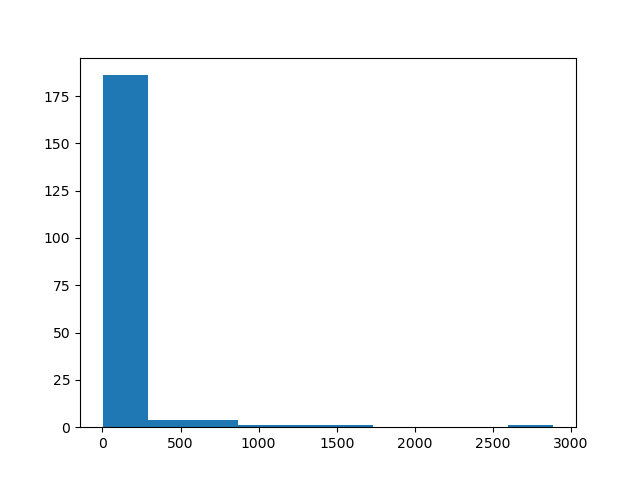

(array([186.,   4.,   4.,   1.,   1.,   1.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 2.8960e+02, 5.7820e+02, 8.6680e+02, 1.1554e+03,
        1.4440e+03, 1.7326e+03, 2.0212e+03, 2.3098e+03, 2.5984e+03,
        2.8870e+03]),
 <BarContainer object of 10 artists>)

In [11]:
fig, ax = plt.subplots()
ax.hist(target_sizes)

---

## 3. Visualising data on a flat map

The first visualisation projects the data on a flat map. There are comments in the code to explain how it works. Using the `zorder` parameter, I make sure to layer the data correctly.

<IPython.core.display.Javascript object>


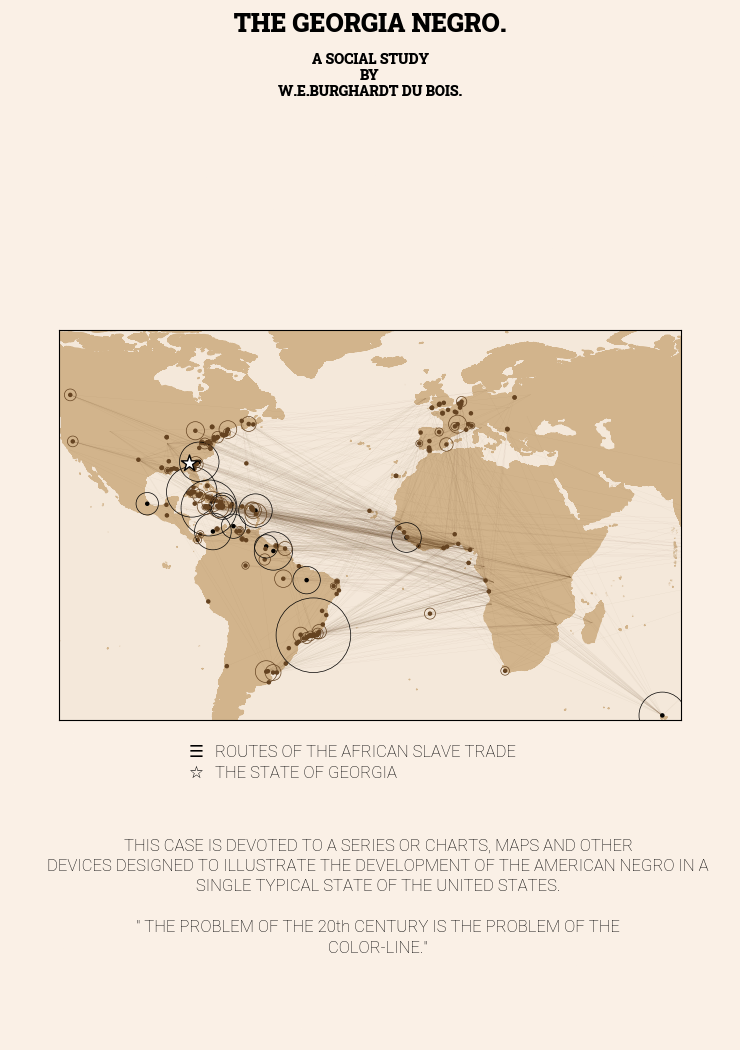

In [14]:
fig, ax = plt.subplots(
    figsize=(7.4,10.5), 
    facecolor=dubois_colors['bg']
)

# load custom fonts
rob_font_heavy = {'fontname':'Roboto Slab', 'fontweight': 'black'}
rob_font_light = {'fontname':'Roboto', 'fontweight': 'light'}

# plot map schap file
gdf_globe.plot(
    # project map to existing axis
    ax=ax, 
    color=dubois_colors.get('tan'), 
    edgecolor=dubois_colors.get('tan')
)

# change position of the map to have the Americas on the left and Afrika on the right.
ax.set_xlim(-125, 75)
ax.set_ylim(-50, 75)

# plot all the routs with a low alpha value
for route in routes:
    ax.plot(route[0], route[1], color=color, alpha=.15, lw=.1, zorder=2)

# plot target dots with a fixed size
ax.scatter(targets_x, targets_y, s=5, zorder=3, facecolor=target_edge_colors)

# plot target dots circle with a size that varies based on the slaves transported there
ax.scatter(targets_x, targets_y, s=target_sizes, lw=.5, zorder=3, facecolor='None', edgecolor=target_edge_colors)

# plot the state of Georgia using latlong
georgia = [32.569669504171166, -83.3378775082368]
ax.scatter(georgia[1], georgia[0], s=150, facecolor='white', edgecolor='black', marker='*', zorder=10)

# set the background color of the plot, appending the hex value 22 to the tan color, making it more transparent. 
ax.set_facecolor(dubois_colors.get('tan')+'22')

# disable these lines if you want to see axes
ax.set_xticks([])
ax.set_yticks([])

# add various titles
plt.title('THE GEORGIA NEGRO.', pad=215, fontsize=18, **rob_font_heavy)
plt.suptitle('A SOCIAL STUDY\nBY\nW.E.BURGHARDT DU BOIS.',  y=.95, **rob_font_heavy, fontsize=10)

# I split the icons for Georgia and the routes, because my custom font (Robot) does not support the symbols
plt.text(
    -90, 
    -55, 
    '''
    ☰ \n
    ☆ 
    ''', 
    va='top', 
    ha='left', 
    fontsize=12, 
    linespacing=.6,
)

plt.text(
    -80, 
    -55, 
    '''
    ROUTES OF THE AFRICAN SLAVE TRADE\n
    THE STATE OF GEORGIA
    ''', 
    va='top', 
    ha='left', 
    fontsize=12, 
    linespacing=.6,
    **rob_font_light
)

plt.text(
    -25, 
    -85, 
    '''
    THIS CASE IS DEVOTED TO A SERIES OR CHARTS, MAPS AND OTHER\n
    DEVICES DESIGNED TO ILLUSTRATE THE DEVELOPMENT OF THE AMERICAN NEGRO IN A\n
    SINGLE TYPICAL STATE OF THE UNITED STATES.\n
    \n
    " THE PROBLEM OF THE 20th CENTURY IS THE PROBLEM OF THE\n
    COLOR-LINE."
    ''', 
    va='top', 
    ha='center', 
    fontsize=12, 
    linespacing=.6,
    **rob_font_light
)

# change plot margins
plt.subplots_adjust(top=1, bottom=0, left=0.08, right=0.92)

## 4. Plotting the data on a globe projection

Alright, this one was a bit more tricky for me. I couldn't figure out how to plot data on a geospatial projection. Somehow, I thought that if I'd assign the projection to an axis, I could simply plot data on it. But that is not the case. I need to convert the data using the projection. It took [this stack overflow comment bay swatchai](https://stackoverflow.com/questions/46620984/how-to-draw-scatter-plot-on-top-of-background-using-basemap) to help me in the right direction. 

Here's the code, it looks similar, but different at some key points.

<IPython.core.display.Javascript object>


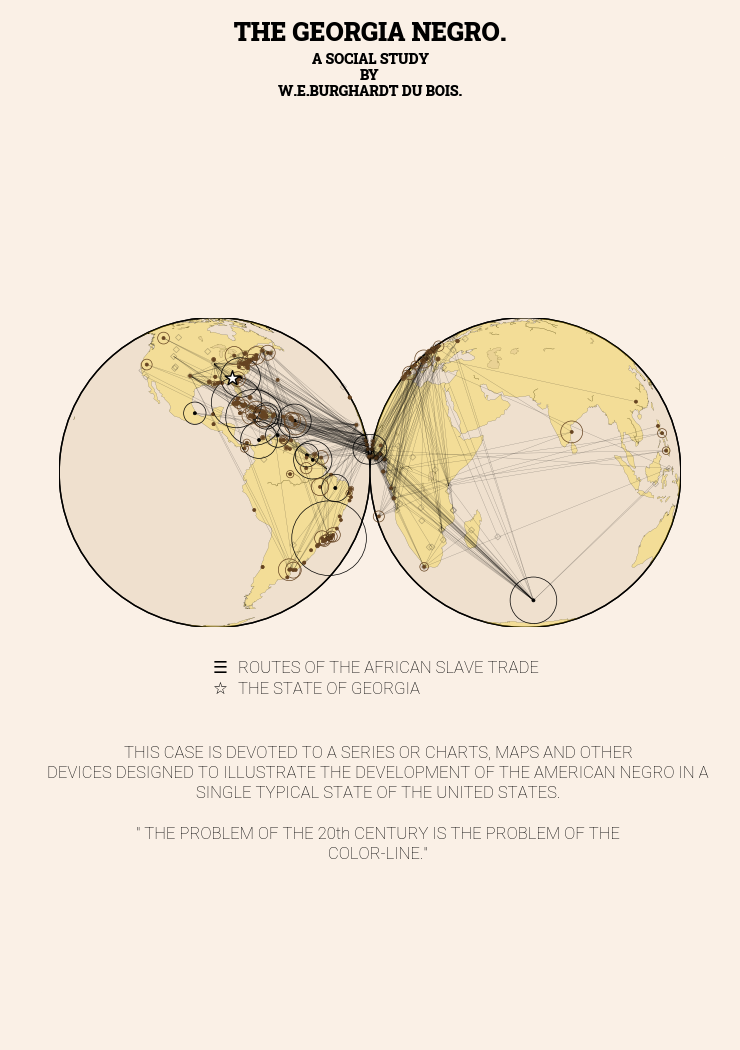

In [17]:
# for the geospatial projections, we need basemap
from mpl_toolkits.basemap import Basemap

# we make to subplots, each will hold a globe
fig, axs = plt.subplots(
    1,2,
    figsize=(7.4,10.5), 
    facecolor=dubois_colors['bg'],
    gridspec_kw={
        # reduce the space between axes to 0
        'wspace': 0,
    }, 
)

# set colours for the map, +44 makes them slightly transparent.
land_color=dubois_colors.get('gold')+'44'
water_color=dubois_colors.get('tan')+'44'

# create two projects, one for the Americas, one for Afrika
# play around with lon_0 go get the projection right
m1 = Basemap(projection='geos',lon_0=-90,resolution='c',rsphere=(6378137.00,6356752.3142), ax=axs[0])
m2 = Basemap(projection='geos',lon_0=65,resolution='c',rsphere=(6378137.00,6356752.3142), ax=axs[1])

# fill the projections with land
m1.drawcoastlines(zorder=2, linewidth=.1)
m1.fillcontinents(color=land_color,lake_color=water_color, zorder=2)
m2.drawcoastlines(zorder=2, linewidth=.1)
m2.fillcontinents(color=land_color,lake_color=water_color, zorder=2)
m1.drawmapboundary(fill_color=water_color, zorder=1) 
m2.drawmapboundary(fill_color=water_color, zorder=1)

# project the targets lat/longs using the m1 projection, then scatter the dots on axis 0

x, y = m1(targets_x, targets_y)
axs[0].scatter(x, y, s=5, lw=.5, zorder=3, facecolor=target_face_colors)
axs[0].scatter(x, y, s=target_sizes, lw=.5, zorder=3, facecolor='none', edgecolor=target_face_colors)

# project the targets lag/longs using the m2 projection, then scatter the dots on axis 1
x, y = m2(targets_x, targets_y)
axs[1].scatter(x, y, s=5, lw=.5, zorder=3, facecolor=target_face_colors)
axs[1].scatter(x, y, s=target_sizes, lw=.5, zorder=3, facecolor='none', edgecolor=target_face_colors)

# similar to the targets, we scatter the sources on both axes, but in a way that puts lets emphasis om them.
x2, y2 = m1(sources_x, sources_y)
axs[0].scatter(
    x2, y2, s=10, lw=.5, zorder=3, alpha=.25, facecolor='none', 
    edgecolor=dubois_colors.get('black'), marker='D'
)

x2, y2 = m2(sources_x, sources_y)
axs[1].scatter(
    x2, y2, s=10, lw=.5, zorder=3, alpha=.25, facecolor='none', 
    edgecolor=dubois_colors.get('black'), marker='D'
)

# plot the routes on both axes
for route in routes:
    x, y = m1(route[0], route[1])
    axs[0].plot(x, y, color='black', alpha=.4, lw=.2, zorder=2)
    
    x, y = m2(route[0], route[1])
    axs[1].plot(x, y, color='black', alpha=.4, lw=.2, zorder=2)

# plot Georgia
gx, gy = m1(-83.3378775082368, 32.569669504171166)
axs[0].scatter(gx, gy, s=125, facecolor='white', edgecolor='black', marker='*', zorder=10)

# add titles
plt.suptitle(
    'A SOCIAL STUDY\nBY\nW.E.BURGHARDT DU BOIS.',  
    y=.95, 
    **rob_font_heavy, fontsize=10
)

# plot various extra texts. 
# Adding transform=fig.transFigure allows you to add relative positions (0-1) within the figure
plt.text(
    .5, 
    .98, 
    'THE GEORGIA NEGRO.', 
    va='top', 
    ha='center', 
    fontsize=18, 
    transform=fig.transFigure,
    **rob_font_heavy
)
plt.text(
    .26, 
    .38, 
    '''
    ☰ \n
    ☆ 
    ''', 
    va='top', 
    ha='left', 
    fontsize=12, 
    linespacing=.6,
    transform=fig.transFigure,
)

plt.text(
    .3, 
    .38, 
    '''
    ROUTES OF THE AFRICAN SLAVE TRADE\n
    THE STATE OF GEORGIA
    ''', 
    va='top', 
    ha='left', 
    fontsize=12, 
    linespacing=.6,
    transform=fig.transFigure,
    **rob_font_light
)

plt.text(
    .5, 
    .30, 
    '''
    THIS CASE IS DEVOTED TO A SERIES OR CHARTS, MAPS AND OTHER\n
    DEVICES DESIGNED TO ILLUSTRATE THE DEVELOPMENT OF THE AMERICAN NEGRO IN A\n
    SINGLE TYPICAL STATE OF THE UNITED STATES.\n
    \n
    " THE PROBLEM OF THE 20th CENTURY IS THE PROBLEM OF THE\n
    COLOR-LINE."
    ''', 
    va='top', 
    ha='center', 
    fontsize=12, 
    linespacing=.6,
    transform=fig.transFigure,
    **rob_font_light
)

# adjust plot margins
plt.subplots_adjust(top=1, bottom=0.1, left=0.08, right=0.92)

plt.savefig('challenge04.png', dpi=300)

Alright. That is it. My main learnings here:

- My first projection of data on a geospatial map projection. Yes!
- Had some troubles adding texts to the final plot, it was somehow different than the flat map projection. But `plt.text` and `transform=fig.transFigure` became two new friends :)